<a href="https://colab.research.google.com/github/heba956/classical/blob/main/deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [19]:
import os
import sys
import argparse
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from io import BytesIO

# def parse_args(argv=None):
#     p = argparse.ArgumentParser(description="Train MLP on spiral dataset and save predictions + model")
#     p.add_argument("--train-x", default="/mnt/data/spiral_data_train.csv", help="training features CSV")
#     p.add_argument("--train-y", default="/mnt/data/spiral_labels_train.csv", help="training labels CSV")
#     p.add_argument("--test-x", default="/mnt/data/spiral_data_test.csv", help="test features CSV to predict")
#     p.add_argument("--out-pred", default="/mnt/data/test_predictions.csv", help="output CSV for predictions")
#     p.add_argument("--out-model", default="/mnt/data/mlp_model.pkl", help="output path for trained model")
#     return p.parse_args(argv)


def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(path)


def main(): # Removed argv argument as argparse is removed
    # Read files from the content directory after they have been uploaded
    train_x_path = "/content/spiral_data_train.csv"
    train_y_path = "/content/spiral_labels_train.csv"
    test_x_path = "/content/spiral_data_test.csv"

    try:
        train_X = safe_read_csv(train_x_path)
        train_y_df = safe_read_csv(train_y_path)
        test_X = safe_read_csv(test_x_path)
    except FileNotFoundError as e:
        print(f"Error: Missing input file: {e}. Please ensure all required files are uploaded.")
        return 1
    except Exception as e:
        print(f"Error reading input files: {e}")
        return 2

    # Convert labels to a 1d integer Series
    if isinstance(train_y_df, pd.DataFrame) and train_y_df.shape[1] > 1:
        train_y = train_y_df.iloc[:, 0]
    else:
        train_y = train_y_df.iloc[:, 0] if isinstance(train_y_df, pd.DataFrame) else train_y_df
    try:
        train_y = train_y.astype(int)
    except Exception:
        # fallback: try to convert via numpy
        train_y = pd.Series(np.asarray(train_y).astype(int))

    print("Train X shape:", train_X.shape)
    print("Train y shape:", train_y.shape)
    print("Test X shape:", test_X.shape)
    print("Label value counts:\n", train_y.value_counts())

    # train/validation split (use stratify if possible)
    try:
        X_tr, X_val, y_tr, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42, stratify=train_y)
        strat = True
    except Exception:
        X_tr, X_val, y_tr, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42, shuffle=True)
        strat = False

    print("Used stratify in split?:", strat)

    # Pipeline: scaler + small MLP for speed
    pipe = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42))

    print("\nTraining MLP classifier (this may take a few seconds)...")
    pipe.fit(X_tr, y_tr)

    train_acc = pipe.score(X_tr, y_tr)
    val_acc = pipe.score(X_val, y_val)

    # cross-validation robust to small classes
    vc = train_y.value_counts()
    min_count = int(vc.min())
    cv_scores = None
    cv_info = ""
    if min_count >= 2:
        cv = min(5, int(min_count))
        try:
            cv_scores = cross_val_score(pipe, train_X, train_y, cv=cv, n_jobs=1)
            cv_info = f"{cv}-fold CV performed."
        except Exception as e:
            cv_scores = None
            cv_info = f"CV error: {e}"
    else:
        cv_info = "Skipped cross-validation because some class has fewer than 2 samples."

    print(f"\nTrain accuracy: {train_acc:.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")
    if cv_scores is not None:
        print(f"{cv}-fold CV accuracies: {cv_scores}")
        print(f"{cv}-fold CV mean accuracy: {cv_scores.mean():.4f}")
    else:
        print("Cross-validation not performed.", cv_info)

    # predictions
    test_preds = pipe.predict(test_X)
    out_df = pd.DataFrame({"label": test_preds})

    # Save predictions and model (using default names or ask user for names)
    # For now, let's keep the default names but save to the current directory
    out_pred_path = "test_predictions.csv"
    out_model_path = "mlp_model.pkl"

    out_df.to_csv(out_pred_path, index=False)
    joblib.dump(pipe, out_model_path)

    print(f"\nSaved test predictions to: {out_pred_path}")
    print(f"Saved trained model to: {out_model_path}")
    return 0

if __name__ == "__main__":
    # Pass an empty list to parse_args when running in an interactive environment like Colab
    if 'ipykernel' in sys.modules:
        sys.exit(main())
    else:
        sys.exit(main())

Train X shape: (2000, 2)
Train y shape: (2000,)
Test X shape: (400, 2)
Label value counts:
 Label
0    1000
1    1000
Name: count, dtype: int64
Used stratify in split?: True

Training MLP classifier (this may take a few seconds)...

Train accuracy: 1.0000
Validation accuracy: 1.0000
5-fold CV accuracies: [1.     1.     1.     1.     0.9975]
5-fold CV mean accuracy: 0.9995

Saved test predictions to: test_predictions.csv
Saved trained model to: mlp_model.pkl


SystemExit: 0

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
!rm "spiral_labels_train (1).csv"

# Task
Visualize the decision boundary of the trained MLP model using the training data.

## Load the model and data

### Subtask:
Load the trained MLP model and the original training data (features and labels).


**Reasoning**:
The subtask requires loading the trained model and the training data. I will load the model using `joblib.load` and the data using `pd.read_csv`. Then I will convert the labels DataFrame to a Series.



In [21]:
import joblib
import pandas as pd

# Load the trained MLP model
model = joblib.load('mlp_model.pkl')

# Load the training data
train_X = pd.read_csv('spiral_data_train.csv')
train_y_df = pd.read_csv('spiral_labels_train.csv')

# Convert labels to a 1d integer Series
train_y = train_y_df.iloc[:, 0]
if isinstance(train_y, pd.DataFrame):
    train_y = train_y.iloc[:, 0]

try:
    train_y = train_y.astype(int)
except Exception:
    # fallback: try to convert via numpy
    train_y = pd.Series(np.asarray(train_y).astype(int))

print("Model loaded:", model)
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)

Model loaded: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000,
                               random_state=42))])
Train X shape: (2000, 2)
Train y shape: (2000,)


## Create a meshgrid

### Subtask:
Generate a meshgrid of points that covers the range of your data's features.


**Reasoning**:
Determine the range of the features and create a meshgrid for visualization.



In [22]:
import numpy as np

# Determine the minimum and maximum values for each feature
x_min, x_max = train_X.iloc[:, 0].min() - 1, train_X.iloc[:, 0].max() + 1
y_min, y_max = train_X.iloc[:, 1].min() - 1, train_X.iloc[:, 1].max() + 1

# Create a meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

print("Meshgrid shapes:", xx.shape, yy.shape)

Meshgrid shapes: (275, 335) (275, 335)


## Predict on the meshgrid

### Subtask:
Use the trained model to predict the class label for each point in the meshgrid.


**Reasoning**:
Flatten the meshgrid arrays, combine them into a single array, and use the trained model to predict the class for each point.



In [23]:
# Flatten the meshgrid arrays
xx_flat = xx.ravel()
yy_flat = yy.ravel()

# Combine into a single array for prediction
meshgrid_points = np.c_[xx_flat, yy_flat]

# Predict the class labels for the meshgrid points
Z = model.predict(meshgrid_points)

print("Shape of meshgrid points for prediction:", meshgrid_points.shape)
print("Shape of predictions:", Z.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Shape of meshgrid points for prediction: (92125, 2)
Shape of predictions: (92125,)


## Visualize the decision boundary

### Subtask:
Plot the meshgrid predictions as a background color map and overlay the original training data points, colored by their true labels.


**Reasoning**:
Plot the decision boundary using the meshgrid predictions and overlay the original training data points.



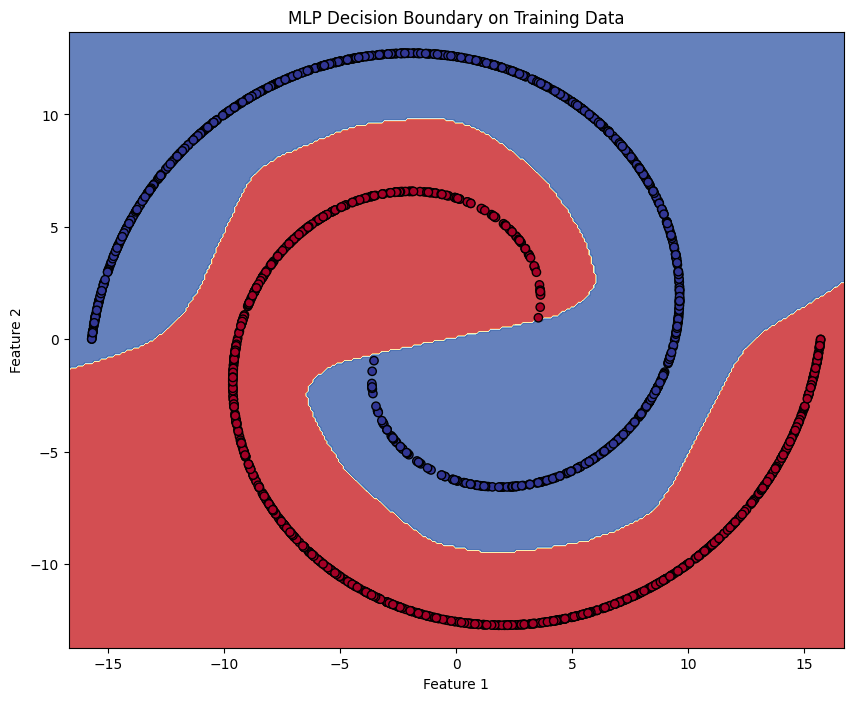

In [24]:
import matplotlib.pyplot as plt

# Reshape the predicted labels Z to match the shape of the meshgrid
Z = Z.reshape(xx.shape)

# Create the contour plot for the decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)

# Create the scatter plot of the original training data
plt.scatter(train_X.iloc[:, 0], train_X.iloc[:, 1], c=train_y, cmap=plt.cm.RdYlBu, edgecolors='k')
plt.title('MLP Decision Boundary on Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Add labels and title

### Subtask:
Add appropriate labels to the axes and a title to the plot for clarity.


## Summary:

### Data Analysis Key Findings

*   The trained MLP model and the training data (features and labels) were successfully loaded. The training features `train_X` have a shape of (2000, 2), and the training labels `train_y` have a shape of (2000,).
*   A meshgrid covering the range of the training data's features was successfully created using `numpy.meshgrid`. The resulting meshgrid arrays `xx` and `yy` have shapes of (275, 335).
*   The trained model successfully predicted the class labels for the meshgrid points. The predictions, stored in `Z`, have a shape of (92125,).
*   The decision boundary of the trained MLP model was visualized using a contour plot of the meshgrid predictions. The original training data points were overlaid on the plot and colored according to their true labels.
*   The plot was titled "MLP Decision Boundary on Training Data" and the axes were labeled "Feature 1" and "Feature 2".

### Insights or Next Steps

*   The visualization clearly shows how the MLP model has learned to separate the different classes within the feature space.
*   A next step could be to visualize the decision boundary on a separate test dataset to evaluate the model's generalization performance.
